# Image viewer

This notebook is for inspecting timelapse microscopy data, with associated sinhgle-cell labels and tracks, showing the infection of human macrophages with Mycobacterium Tuberculosis (Mtb), acquired on an Opera Phenix confocal microscope. 

In [1]:
import napari
from macrohet import dataio, tile, visualise, tools
import os, glob
from tqdm.auto import tqdm
from skimage import io
import numpy as np
from macrohet.notify import send_sys_message as notify
import btrack
import zarr
import matplotlib.pyplot as plt
import json

In [2]:
os.getpid()

16903

In [3]:
def update_slider(event):
    # only trigger if update comes from first axis (optional
        #ind_lambda = viewer.dims.indices[0]
    time = viewer.dims.current_step[0]
    viewer.text_overlay.text = f"{time/2:1.1f} hours"
text_size = 24
napari_scale = [1.4949402023919043e-07, 1.4949402023919043e-07]

label_text_size = 15
### glimpse size
size = 500
### resized images are to this scale
scale = 6048/1200
scale_factor = 1/5.04
from napari_animation import Animation


### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.


In [4]:

%%time
expt_ID = 'ND0002'
# base_dir = f'/mnt/DATA/macrohet/{expt_ID}/'
base_dir = f'/mnt/SYNO/macrohet_syno/{expt_ID}/'
metadata_fn = glob.glob(os.path.join(base_dir, 'acquisition/Images/Index*xml'))[0]
# metadata_fn = '/mnt/SYNO/macrohet_syno/ND0001/acquisition/ND0001__2023-10-27T14_12_54-Measurement 1/Images/Index.idx.xml'#glob.glob(os.path.join(base_dir, 'Images/Index*xml'))[0]
metadata = dataio.read_harmony_metadata(metadata_fn)  
# temporary hack to fix URL from incorrectly exported metadata
# metadata['URL'] = metadata.apply(dataio.generate_url, axis=1)
metadata

Reading metadata XML file...


0it [00:00, ?it/s]

Extracting metadata complete!
CPU times: user 37.7 s, sys: 3.08 s, total: 40.8 s
Wall time: 40.7 s


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0103K1F1P1R1,Ok,r01c03f01p01-ch1sk1fk1fl1.tiff,1,3,1,1,0,1,1,...,-2E-06,0.135466397,0,2023-11-30T17:22:09.49+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
1,0103K1F1P1R2,Ok,r01c03f01p01-ch2sk1fk1fl1.tiff,1,3,1,1,0,2,1,...,-2E-06,0.135466397,0,2023-11-30T17:22:09.723+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
2,0103K1F1P2R1,Ok,r01c03f01p02-ch1sk1fk1fl1.tiff,1,3,1,2,0,1,1,...,0,0.135468394,0,2023-11-30T17:22:10.067+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
3,0103K1F1P2R2,Ok,r01c03f01p02-ch2sk1fk1fl1.tiff,1,3,1,2,0,2,1,...,0,0.135468394,0,2023-11-30T17:22:10.287+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
4,0103K1F1P3R1,Ok,r01c03f01p03-ch1sk1fk1fl1.tiff,1,3,1,3,0,1,1,...,2E-06,0.135470405,0,2023-11-30T17:22:10.627+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388615,0612K150F9P1R2,Ok,r06c12f09p01-ch2sk150fk1fl1.tiff,6,12,9,1,149,2,1,...,-2E-06,0.1351538,268191.66,2023-12-03T20:06:16.08+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
388616,0612K150F9P2R1,Ok,r06c12f09p02-ch1sk150fk1fl1.tiff,6,12,9,2,149,1,1,...,0,0.135155797,268191.66,2023-12-03T20:06:16.423+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
388617,0612K150F9P2R2,Ok,r06c12f09p02-ch2sk150fk1fl1.tiff,6,12,9,2,149,2,1,...,0,0.135155797,268191.66,2023-12-03T20:06:16.657+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
388618,0612K150F9P3R1,Ok,r06c12f09p03-ch1sk150fk1fl1.tiff,6,12,9,3,149,1,1,...,2E-06,0.135157794,268191.66,2023-12-03T20:06:17+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [5]:
metadata_path = glob.glob(os.path.join(base_dir, 'acquisition/Assaylayout/*AssayLayout.xml'))[0]
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
Row Column                                              
3   1         UNI     CTRL             0             EC0
    2         UNI     CTRL             0             EC0
    3          WT     CTRL             0             EC0
    4          WT     CTRL             0             EC0
    5          WT      PZA            60            EC50
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      RIF           0.1            EC50
    9          WT      INH          0.04            EC50
    10         WT      INH          0.04            EC50
    11         WT      BDQ          0.02            EC50
    12         WT      BDQ          0.02            EC50
4   3          WT     CTRL             0             EC0
    4          WT     CTRL             0             EC0
    5          WT      PZA           400            EC99
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      RIF             2            EC99
    9          WT      INH             2            EC99
    10         WT      INH             2            EC99
    11         WT      BDQ           2.5            EC99
    12         WT      BDQ           2.5            EC99
5   3         RD1     CTRL             0             EC0
    4         RD1     CTRL             0             EC0
    5         RD1      PZA            60            EC50
    6         RD1      PZA            60            EC50
    7         RD1      RIF           0.1            EC50
    8         RD1      RIF           0.1            EC50
    9         RD1      INH          0.04            EC50
    10        RD1      INH          0.04            EC50
    11        RD1      BDQ          0.02            EC50
    12        RD1      BDQ          0.02            EC50
6   3         RD1     CTRL             0             EC0
    4         RD1     CTRL             0             EC0
    5         RD1      PZA           400            EC99
    6         RD1      PZA           400            EC99
    7         RD1      RIF             2            EC99
    8         RD1      RIF             2            EC99
    9         RD1      INH             2            EC99
    10        RD1      INH             2            EC99
    11        RD1      BDQ           2.5            EC99
    12        RD1      BDQ           2.5            EC99

### Define row and column of choice

In [6]:
acq_ID = row, column = (3, 4)

### Load images using zarr

In [7]:
zarr_image_dir = os.path.join(base_dir, f'acquisition/zarr/{acq_ID}.zarr')
zarr_store = zarr.open(zarr_image_dir, mode='r')

In [8]:
%%time
zarr_images = zarr_store.images[0:20] #.compute()

CPU times: user 5.22 s, sys: 3.04 s, total: 8.26 s
Wall time: 2.3 s


In [9]:
zarr_images.shape

(20, 2, 3, 6048, 6048)

In [10]:
images = zarr_images = np.max(zarr_images, axis = 2)

In [11]:
images.shape


(20, 2, 6048, 6048)

### Launch napari

In [12]:
viewer = napari.Viewer(title = f'{expt_ID} vis with tracks')

viewer.add_image(images, channel_axis = 1, 
                 scale = napari_scale, contrast_limits=[[280, 1000],[0,3000]])
# viewer.theme = 'light'
viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'm'
viewer.scale_bar.font_size = text_size
viewer.text_overlay.visible = True
viewer.text_overlay.color = 'white'
viewer.text_overlay.position = 'bottom_left'
viewer.text_overlay.font_size = text_size
viewer.dims.events.current_step.connect(update_slider)

<function __main__.update_slider(event)>

In [13]:
%%time
# image_dir = os.path.join(base_dir, 'macrohet_images/Images_8bit')
image_dir = os.path.join(base_dir, 'acquisition/Images')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             # subset_field_IDs=['16', '17',  '20', '21'], 
                             # n_tile_rows = 2, n_tile_cols = 2,
                             set_plane='max_proj',
                             # set_channel=1,
                             # set_time = 1,
#                             input_transforms = [input_transforms]
                            )#.compute().compute()
images

CPU times: user 1.23 s, sys: 375 ms, total: 1.61 s
Wall time: 1.5 s


dask.array<max-aggregate, shape=(150, 2, 6048, 6048), dtype=uint16, chunksize=(1, 2, 2160, 2160), chunktype=numpy.ndarray>

In [14]:
%%time
images = images.compute()

CPU times: user 6min 44s, sys: 20.5 s, total: 7min 4s
Wall time: 4min 59s


### Load default segmentation 

In [4]:
fn = '/mnt/SYNO/macrohet_syno/ND0002/labels/(3, 4)_dev/testing_(3, 4)_config_segrate_0.05_probass_0.05.json.h5'
with btrack.io.HDF5FileHandler(fn, 'r', obj_type='obj_type_1') as reader:
    segmentation = reader.segmentation
    tracks = reader.tracks
    objects = reader.objects
# recolored_segmentation = btrack.utils.update_segmentation(seg, tracks ,scale = (1/scale_factor,1/scale_factor))


[INFO][2024/01/26 09:37:07 AM] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/(3, 4)_dev/testing_(3, 4)_config_segrate_0.05_probass_0.05.json.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/(3, 4)_dev/testing_(3, 4)_config_segrate_0.05_probass_0.05.json.h5...
[INFO][2024/01/26 09:37:27 AM] Loading segmentation (150, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (150, 6048, 6048)
[INFO][2024/01/26 09:37:27 AM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/26 09:37:27 AM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/26 09:37:27 AM] Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
[INFO][2024/01/26 09:37:29 AM] Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
[INFO][2024/01/26 09:37:30

In [5]:
len(tracks)

27742

In [6]:
len([t for t in tracks if len(t) > 70])

102

In [8]:
len([t for t in tracks if len(t) > 140])

13

In [9]:
objects[0]

,ID,x,y,z,t,dummy,states,label,orientation,class_id,area,minor_axis_length,major_axis_length,eccentricity
0,0,817.460327,561.904785,0.0,0,False,7,5,0.785398,186.0,1.0,0.0,0.0,0.0


In [11]:
len([o for o in objects if o.properties['area']>5000 and o.t==0])

391

# adding fluorescence measurements

In [16]:
intensity_image = images = np.stack([images[:,0,...], images[:,1,...]], axis = -1)

In [17]:
intensity_image.shape

(150, 6048, 6048, 2)

In [18]:
properties = tuple(['major_axis_length',
                    'area',
                    'minor_axis_length',
                    'orientation',
                    'eccentricity', 
                    'mean_intensity', 
                    'max_intensity', 
                    'min_intensity']
                  )

In [19]:
use_weighted_centroid = False

In [20]:
filtered_masks = tools.remove_small_segments(segmentation, threshold_size=5000)

Iterating over frames:   0%|          | 0/150 [00:00<?, ?it/s]

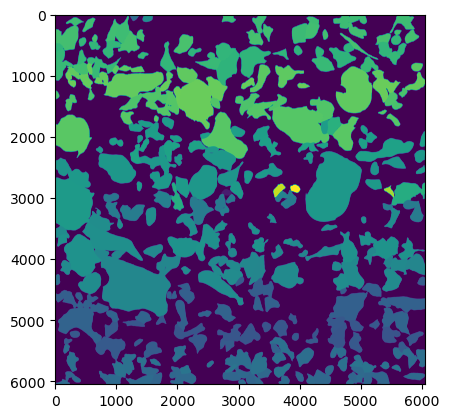

In [21]:
plt.imshow(filtered_masks[0])

### FULLY RELOCALISE and add flo int

In [22]:
tracking_scale_factor = 1800/6048

In [23]:
filtered_masks = filtered_masks[0:20]

In [24]:
objects = btrack.utils.segmentation_to_objects(segmentation=filtered_masks,
                                               intensity_image=intensity_image, 
                                               properties=properties,
                                               scale=(tracking_scale_factor,tracking_scale_factor),
                                               use_weighted_centroid=False, 
                                               assign_class_ID=True, 
                                             
                                           )

[INFO][2024/01/25 04:56:32 pm] Localizing objects from segmentation...
INFO:btrack.io._localization:Localizing objects from segmentation...
[WARNING][2024/01/25 04:56:32 pm] Multichannel intensity image detected, using unweighted centroid.
100%|██████████████████████████████████████████████████████████| 20/20 [03:47<00:00, 11.38s/it]
[INFO][2024/01/25 05:00:19 pm] Objects are of type: <class 'dict'>
INFO:btrack.io.utils:Objects are of type: <class 'dict'>
[INFO][2024/01/25 05:00:19 pm] ...Found 6745 objects in 20 frames.
INFO:btrack.io._localization:...Found 6745 objects in 20 frames.


### scaling objects back down 

In [25]:
import datetime

In [26]:

area_threshold = 5000

filtered_objs = [obj for obj in objects if obj.properties['area'] > area_threshold]
# initialise a tracker session using a context manager

In [27]:
list(filtered_objs[0].properties.keys())

['major_axis_length',
 'area',
 'minor_axis_length',
 'orientation',
 'eccentricity',
 'mean_intensity',
 'max_intensity',
 'min_intensity',
 'class_id']

In [28]:
img_props = [ 'mean_intensity',
             'max_intensity',
             'min_intensity',]

In [29]:
viewer.add_labels(filtered_masks, scale=napari_scale)

<Labels layer 'filtered_masks' at 0x7f19057551c0>

In [ ]:
new_config_fn = config_fn = '/home/dayn/analysis/models/btrack/particle_config_pnassign.json'

# Load the JSON data from the original file
with open(config_fn, 'r') as json_file:
    data = json.load(json_file)

# Edit the parameters
data['TrackerConfig']['MotionModel']['prob_not_assign'] = 1  # Change the value of prob_not_assign
data['TrackerConfig']['HypothesisModel']['lambda_time'] = 6.0  # Change the value of lambda_time
data['TrackerConfig']['HypothesisModel']['lambda_dist'] = 4 #4.0   # Change the value of lambda_dist
data['TrackerConfig']['HypothesisModel']['lambda_link'] = 11 #11.0  # Change the value of lambda_link
data['TrackerConfig']['HypothesisModel']['lambda_branch'] = 0 # dont matter unless you have classifications # 55.0  # Change the value of lambda_branch
data['TrackerConfig']['HypothesisModel']['eta'] = 1e-11  # Change the value of eta
data['TrackerConfig']['HypothesisModel']['theta_dist'] = 25.0 # 25.0 # Change the value of theta_dist
data['TrackerConfig']['HypothesisModel']['theta_time'] = 6.0  # Change the value of theta_time
data['TrackerConfig']['HypothesisModel']['dist_thresh'] = 20 #45  # Change the value of dist_thresh
data['TrackerConfig']['HypothesisModel']['time_thresh'] = 3  # Change the value of time_thresh
data['TrackerConfig']['HypothesisModel']['apop_thresh'] = 0 # doesnt matter unless oyu have classificiation # 6  # Change the value of apop_thresh
data['TrackerConfig']['HypothesisModel']['segmentation_miss_rate'] = 0.05  # Change the value of segmentation_miss_rate
data['TrackerConfig']['HypothesisModel']['apoptosis_rate'] = 0 # 0.00002 # doesnt matter unless you have apop classification # Change the value of apoptosis_rate

new_config_fn = 'test_config.json' #'/home/dayn/analysis/models/btrack/particle_config_pnassign.json'
# Save the modified data to a new JSON file
with open('test_config.json', 'w') as json_file:
    json.dump(data, json_file, indent=4)

# search radius
search_radius = 20

with btrack.BayesianTracker() as tracker:
    # configure the tracker using a config file
    tracker.configure(new_config_fn)
    # set max search radius
    tracker.max_search_radius = search_radius
    # define tracking method
    tracker.tracking_updates = ["MOTION", "VISUAL"]
    # redefine features so that both channels are included in track measurements
    tracker.features = ['mean_intensity'] # img_props #list(filtered_objs[0].properties.keys())
    # append the objects to be tracked
    tracker.append(filtered_objs)
    # set the tracking volume
    tracker.volume=((0, filtered_masks.shape[-2]*tracking_scale_factor), (0, filtered_masks.shape[-1]*tracking_scale_factor))
    # track them (in interactive mode)
    tracker.track(step_size=25)
    # generate hypotheses and run the global optimizer
    tracker.optimize()
    # store the tracks
    tracks = tracker.tracks
time_stamp = datetime.datetime.now().strftime("%H:%M")
with btrack.io.HDF5FileHandler(os.path.join(base_dir, f'labels/test_{time_stamp}.h5'), 
                                   'w', 
                                   obj_type='obj_type_1'
                                   ) as writer:
#             writer.write_objects(objects)
        writer.write_tracks(tracks)
        # writer.write_segmentation(recolored_segmentation)
napari_tracks, _, _ = btrack.utils.tracks_to_napari(tracks, ndim = 2)
viewer.add_tracks(napari_tracks, name = f'tracks from {time_stamp}', scale = (napari_scale[0]/tracking_scale_factor,napari_scale[0]/tracking_scale_factor))

[INFO][2024/01/25 05:00:20 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2024/01/25 05:00:20 pm] Starting BayesianTracker session
INFO:btrack.core:Starting BayesianTracker session
[INFO][2024/01/25 05:00:20 pm] Loading configuration file: test_config.json
INFO:btrack.config:Loading configuration file: test_config.json
[INFO][2024/01/25 05:00:20 pm] Objects are of type: <class 'list'>
INFO:btrack.io.utils:Objects are of type: <class 'list'>
[INFO][2024/01/25 05:00:20 pm] Starting tracking... 
INFO:btrack.core:Starting tracking... 
[INFO][2024/01/25 05:00:20 pm] Update using: ['MOTION', 'VISUAL']
INFO:btrack.core:Update using: ['MOTION', 'VISUAL']


In [ ]:
tools.track_euc_dist(t1)

In [1]:
tracks

NameError: name 'tracks' is not defined

In [10]:
fn = '/mnt/SYNO/macrohet_syno/ND0002/labels/big scale.h5'
with btrack.io.HDF5FileHandler(fn, 'r', obj_type='obj_type_1') as reader:
    # segmentation = reader.segmentation
    # tracks = reader.tracks
    objects = reader.objects

[INFO][2024/01/26 04:28:45 PM] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/big scale.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/big scale.h5...
[INFO][2024/01/26 04:28:45 PM] Loading objects/obj_type_1 (49773, 5) (49773 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (49773, 5) (49773 filtered: None)
[INFO][2024/01/26 04:28:46 PM] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/big scale.h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/big scale.h5


In [13]:
obj = objects[0]

In [15]:
obj.properties['mean_intensity'][0]

116.670746

In [12]:
print()